##   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2021, MBARI</div>
    
  * Distributed under the terms of the GPL License
  * Maintainer: dcline@mbari.org
  * Authors: Danelle Cline dcline@mbari.org, John Ryan ryjo@mbari.org

## Basic Exploration of the 2 kHz Pacific Ocean Audio Data in the AWS Open Data Registry

---
An extensive (5+ years and growing) archive of sound recordings from a deep-sea location [along the eastern margin of the North Pacific Ocean](https://www.mbari.org/at-sea/cabled-observatory/) has been made available through AWS Open data.  Temporal coverage of the recording archive has been 95% since project inception in July 2015.  The original recordings have a sample rate of 256 kHz.  For many research applications it is convenient to work with data having a lower sample rate.  This notebook illustrates basic methods to access and process a calibrated spectrogram from the decimated 2 kHz audio archive.

If you use this data set, please **[cite our project](https://ieeexplore.ieee.org/document/7761363).**


## Data Overview
The decimated audio data are in [WAV](https://en.wikipedia.org/wiki/WAV) format in an s3 bucket named <b>pacific-sound-2khz</b>.  They are further organized by year and month.  Buckets are stored as objects, so the data isn't physically stored in folders or directories as you may be famaliar with, but you can think of it conceptually as follows:

```
pacific-sound-2khz
      |
      ----2020
        |
        |----01
        ...
        |----12
```


## Install required dependencies

First, let's install the required software dependencies. 

If you are using this notebook in a cloud environment, select a Python3 compatible kernel and run this next section.  This only needs to be done once for the duration of this notebook.

If you are working on local computer, you can skip this next cell. Change your kernel to *pacific-sound-notebooks*, which you installed according to the instructions in the [README](https://github.com/mbari-org/pacific-sound-notebooks/) - this has all the dependencies that are needed. 

In [1]:
!pip install -q boto3 --quiet
!pip install -q soundfile --quiet
!pip install -q scipy --quiet
!pip install -q numpy --quiet
!pip install -q matplotlib --quiet

     |████████████████████████████████| 132 kB 5.0 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 9.2 MB 54.7 MB/s 
     |████████████████████████████████| 140 kB 55.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


### Import all packages

In [2]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import scipy
from scipy import signal
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

## List the contents of a monthly directory

In [3]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='', 
    config=Config(signature_version=UNSIGNED))

In [4]:
year = 2020
month = 1
bucket = 'pacific-sound-2khz'

for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year:04d}/{month:02d}')['Contents']:
    print(obj['Key'])

2020/01/MARS-20200101T000000Z-2kHz.wav
2020/01/MARS-20200102T000000Z-2kHz.wav
2020/01/MARS-20200103T000000Z-2kHz.wav
2020/01/MARS-20200104T000000Z-2kHz.wav
2020/01/MARS-20200105T000000Z-2kHz.wav
2020/01/MARS-20200106T000000Z-2kHz.wav
2020/01/MARS-20200107T000000Z-2kHz.wav
2020/01/MARS-20200108T000000Z-2kHz.wav
2020/01/MARS-20200109T000000Z-2kHz.wav
2020/01/MARS-20200110T000000Z-2kHz.wav
2020/01/MARS-20200111T000000Z-2kHz.wav
2020/01/MARS-20200112T000000Z-2kHz.wav
2020/01/MARS-20200113T000000Z-2kHz.wav
2020/01/MARS-20200114T000000Z-2kHz.wav
2020/01/MARS-20200115T000000Z-2kHz.wav
2020/01/MARS-20200116T000000Z-2kHz.wav
2020/01/MARS-20200117T000000Z-2kHz.wav
2020/01/MARS-20200118T000000Z-2kHz.wav
2020/01/MARS-20200119T000000Z-2kHz.wav
2020/01/MARS-20200120T000000Z-2kHz.wav
2020/01/MARS-20200121T000000Z-2kHz.wav
2020/01/MARS-20200122T000000Z-2kHz.wav
2020/01/MARS-20200123T000000Z-2kHz.wav
2020/01/MARS-20200124T000000Z-2kHz.wav
2020/01/MARS-20200125T000000Z-2kHz.wav
2020/01/MARS-20200126T000

## Retrieve metadata for a file

In [5]:
year = 2020
month = 1
filename = 'MARS-20200101T000000Z-2kHz.wav'
bucket = 'pacific-sound-2khz'
key = f'{year:04d}/{month:02d}/{filename}'

url = f'https://{bucket}.s3.amazonaws.com/{key}'

sf.info(io.BytesIO(urlopen(url).read(20_000)), verbose=True) 

samplerate: 2000 Hz
channels: 1
duration: 3.278 s
format: WAV (Microsoft) [WAV]
subtype: Signed 24 bit PCM [PCM_24]
endian: FILE
sections: 1
frames: 6556
extra_info: """
    Length : 20000
    RIFF : 518400324 (should be 19992)
    WAVE
    fmt  : 16
      Format        : 0x1 => WAVE_FORMAT_PCM
      Channels      : 1
      Sample Rate   : 2000
      Block Align   : 3
      Bit Width     : 24
      Bytes/sec     : 6000
    LIST : 280
      INFO
        INAM : MBARI ocean audio data, start 20200101T000000 UTC
        ICMT : If you use these data, please cite https://doi.org/10.1109/OCEANS.2016.7761363. Recording metadata can be found at https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json.
    data : 518400000 (should be 19668)
    End
    """

## Calibrated Spectrum Levels

### Produce calibrated spectrogram for a full day
For the low-frequency (2 kHz) data, calibration data are not frequency dependent; a single low-frequency calibration value is used.  Its value depends on time of data collection, as two hydrophones have been deployed sequentially at the same site.  Before 14 June 2017, the calibration value is -168.8 dB re V / uPa (measured at 26 Hz).  After this date the value is -177.9 dB re V / uPa (measured at 250 Hz).  See also:


*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment01.json
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json




In [6]:
# create a 1-Hz x n second calibrated spectrogram at 1 second resolution
print(f'Reading from {url}')
x, sample_rate = sf.read(io.BytesIO(urlopen(url).read()),dtype='float32') 
v = x*3   # convert scaled voltage to volts
v.shape, v.size, sample_rate
a = np.arange(v.size)+1
# define segment processing
nsec = (v.size)/sample_rate # number of seconds in vector
spa = 60  # seconds per average
nseg = int(nsec/spa)
print(f'{nseg} segments of length {spa} seconds in {nsec} seconds of audio')

Reading from https://pacific-sound-2khz.s3.amazonaws.com/2020/01/MARS-20200101T000000Z-2kHz.wav
1440 segments of length 60 seconds in 86400.0 seconds of audio


In [7]:
# initialize empty LTSA
nfreq = int(sample_rate/2+1)
nfreq,nseg
LTSA = np.empty((nfreq, nseg), float)
LTSA.shape

(1001, 1440)

In [8]:
# get window for welch
w = scipy.signal.get_window('hann',sample_rate)

# process LTSA
for x in range(0,nseg):
  cstart = x*spa*sample_rate
  cend = (x+1)*spa*sample_rate
  f,psd = scipy.signal.welch(v[cstart:cend],fs=sample_rate,window=w,nfft=sample_rate)
  psd = 10*np.log10(psd) + 177.9
  LTSA[:,x] = psd

In [9]:
nsec, nseg, LTSA.shape

(86400.0, 1440, (1001, 1440))

### Plot the calibrated spectrogram
Note: The sharp drop in signal approaching 1 kHz reflects the attributes of the decimation filter applied to produce the 2 kHZ data from the original 256 kHz data.

Text(0.5, 1.0, 'Calibrated spectrum levels')

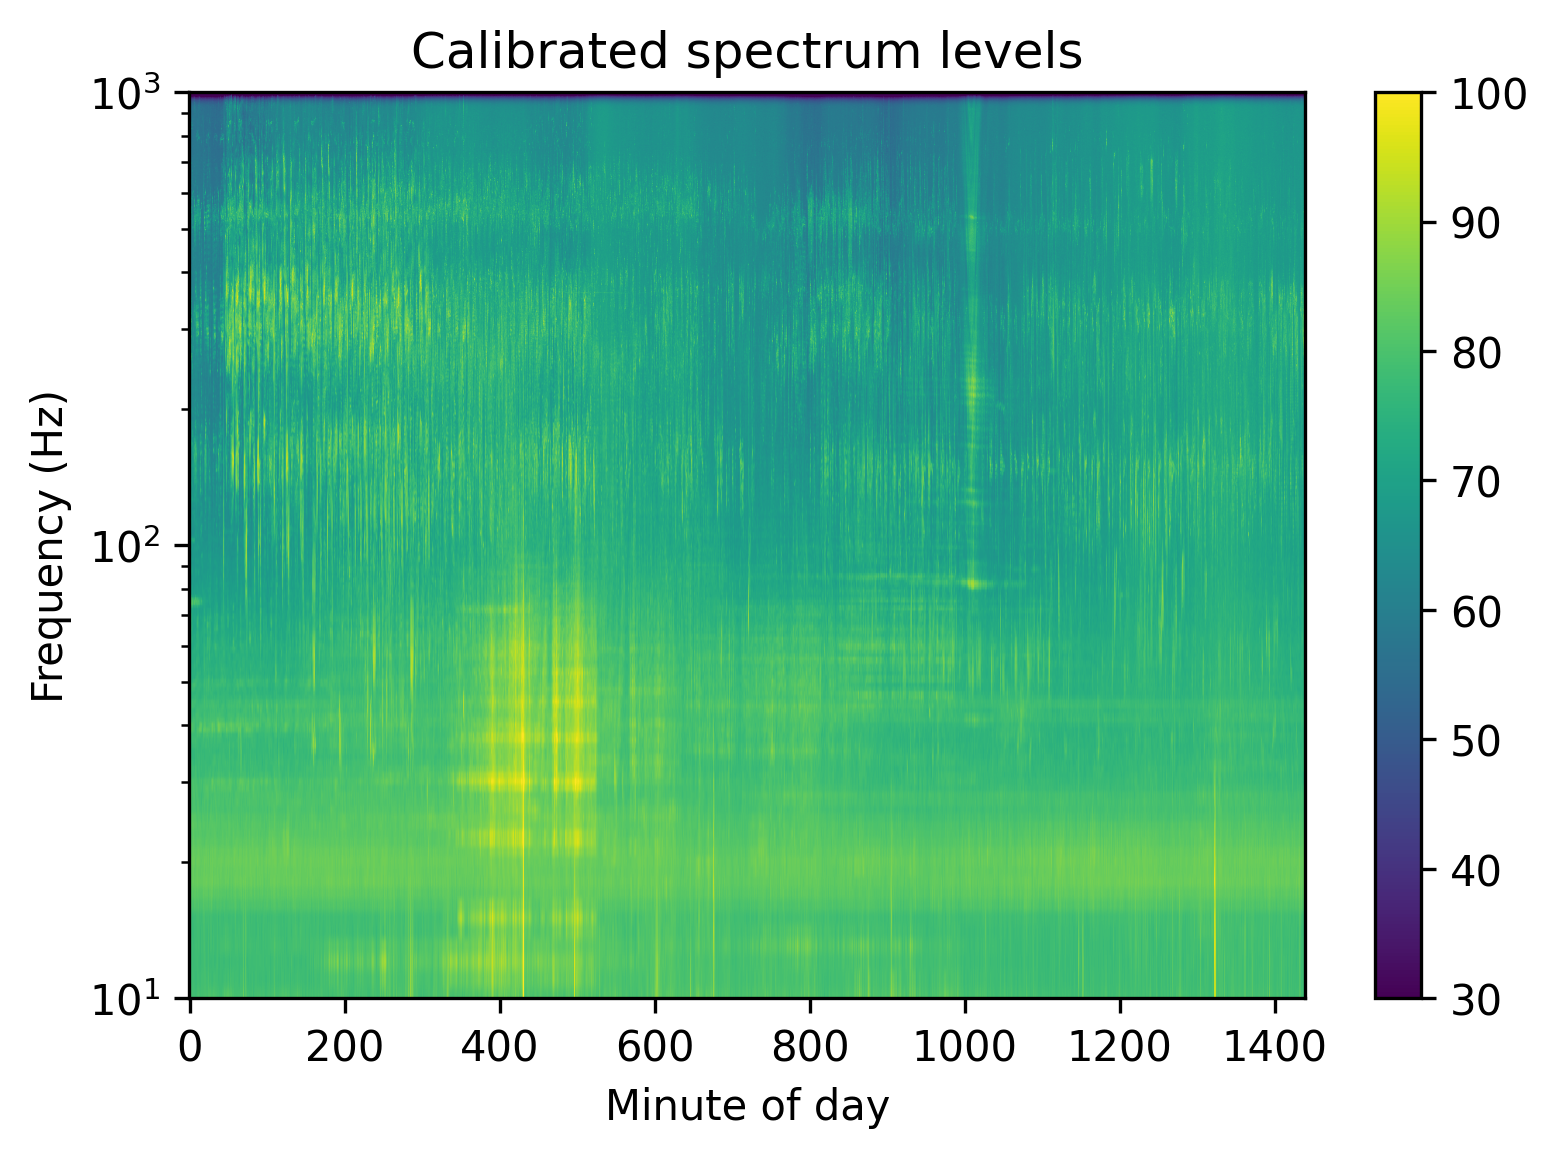

In [10]:
plt.figure(dpi=300)
im = plt.imshow(LTSA,aspect='auto',origin='lower',vmin=30,vmax=100)
plt.yscale('log')
plt.ylim(10,1000)
plt.colorbar(im)
plt.xlabel('Minute of day')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')